# Deer fellow inspirator.

Do not forget to follow me on github na ja ;)

### Import Libraries / Prepare function and Neural Network (Using Code from the class)

In [1]:
# Import neccessary libraries
import sys
import numpy as np
import time
import os
import logging
from collections import Counter
from datetime import datetime
import math

from tqdm import tqdm  #gimmick for progressbar when you train
import pickle #saving and loading models

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#basically, it takes the current state of the buffer, stack, dependencies
#tell us how SHIFT, LA, RA changes these three objects

class Parsing(object):
    
    #init stack, buffer, dep
    def __init__(self, sentence):  
        self.sentence = sentence     #['The', 'cat', 'sat]  #conll format which is already in the tokenized form
        self.stack    = ['ROOT']
        self.buffer   = sentence[:]  #in the beginning, everything is inside the buffer
        self.dep      = []           #maintains a list of tuples of dep
    
    #parse function that tells me how shift, la, ra changes these three objects
    def parse_step(self, transition):     #transition could be either S, LA, RA
        if transition == 'S':
            #get the top guy in the buffer and put in stack
            head = self.buffer.pop(0)
            self.stack.append(head)
        elif transition == 'LA':  #stack = [ROOT, He, has] ==> append to dep (has, he) and then He is gone from the stack [ROOT, has]
            dependent = self.stack.pop(-2)  #He
            self.dep.append((self.stack[-1], dependent))  #(has, he)
        elif transition == 'RA':
            #can you guys try to this???
            dependent = self.stack.pop()  #stack = [ROOT, has, control] ==> dep (has, control), control will be gone fromt he stack [ROOT, has]
            self.dep.append((self.stack[-1], dependent))
        else:
            print(f"Bad transition: {transition}")
    
    #given some series of transition, it gonna for-loop the parse function
    def parse(self, transitions):
        for t in transitions:
            self.parse_step(t)
        return self.dep
    
    #check whether things are finished - no need to do anymore functions....
    def is_completed(self):
        return (len(self.buffer) == 0) and (len(self.stack) == 1)  #so buffer is empty and ROOT is the only guy in stack

In [3]:
def minibatch_parse(sentences, model, batch_size):
    dep = []  #all the resulting dep
    
    #init Parsing instance for each sentence in the batch
    partial_parses = [Parsing(sentence) for sentence in sentences]  #in tokenized form
    #Parsing(['The', 'cat', 'sat']), Parsing(['Chaky', 'is', 'mad'])
    
    unfinished_parses = partial_parses[:]
    
    #while we still have sentence
    while unfinished_parses:  #if there are still a Parsing object
    
        #take a certain batch of sentence
        minibatch = unfinished_parses[:batch_size] #number of Parsing object
        
        #create a dummy model to tell us what's the next transition for each sentence
        transitions = model.predict(minibatch) 
        #transitions = [S, S, .....]
        #minibatch   = [Parsing(sentence1), Parsing(sentence2)]
        
                
        # for transition predicted this dummy model
        for transition, partial_parse in zip(transitions, minibatch):
            #parse step
            #transition: S
            #partial_parse: Parsing(sentence)
            partial_parse.parse_step(transition)
            
        #remove any sentence is finish
        unfinished_parses[:] = [p for p in unfinished_parses if not p.is_completed()]
    
    dep = [parse.dep for parse in partial_parses]
    
    return dep

In [4]:
def read_conll(filename):
    
    examples = []
    
    with open(filename) as f:
        i = 0
        word, pos, head, dep = [], [], [], []
        for line in f.readlines():
            i = i+1
            wa = line.strip().split('\t')  #['1', 'In', '_', 'ADP', 'IN', '_', '5', 'case', '_', '_']
            #In <--------  5th guy
            #     case
            
            if len(wa) == 10:  #if all the columns are there
                word.append(wa[1].lower())
                pos.append(wa[4])
                head.append(int(wa[6]))
                dep.append(wa[7])
            
            #the row is not exactly 10, it means new sentence
            elif len(word) > 0:  #if there is somethign inside the word
                examples.append({'word': word, 'pos': pos, 'head': head, 'dep': dep})  #in the sentence level
                word, pos, head, dep = [], [], [], [] #clear word, pos, head, dep
        
        if len(word) > 0:  #if there is somethign inside the word
            examples.append({'word': word, 'pos': pos, 'head': head, 'dep': dep})  #in the sentence level

    return examples                

In [5]:
def load_data():
    print("1. Loading data")
    train_set = read_conll("/root/projects/NLP/Assignment/26_Jan_Depedency_Parser/Penn_TreeBank_ConLL/train.conll")
    dev_set   = read_conll("/root/projects/NLP/Assignment/26_Jan_Depedency_Parser/Penn_TreeBank_ConLL/dev.conll")
    test_set   = read_conll("/root/projects/NLP/Assignment/26_Jan_Depedency_Parser/Penn_TreeBank_ConLL/test.conll")
    
    #make my dataset smaller because my mac cannot handle it
    train_set = train_set[:1000]
    dev_set   = dev_set[:500]
    test_set  = test_set[:500]
    
    return train_set, dev_set, test_set

In [6]:
P_PREFIX = '<p>:' #indicating pos tags
D_PREFIX = '<d>:' #indicating dependency tags
UNK      = '<UNK>'
NULL     = '<NULL>'
ROOT     = '<ROOT>'

class Parser(object):

    def __init__(self, dataset):
        
        #set the root dep
        self.root_dep = 'root'
                
        #get all the dep of the dataset as list, e.g., ['root', 'acl', 'nmod', 'nmod:npmod']
        all_dep = [self.root_dep] + list(set([w for ex in dataset
                                               for w in ex['dep']
                                               if w != self.root_dep]))
        
        #1. put dep into tok2id lookup table, with D_PREFIX so we know it is dependency
        #{'D_PREFIX:root': 0, 'D_PREFIX:acl': 1, 'D_PREFIX:nmod': 2, ..., 'D_PREFIX:<NULL>': 30}
        tok2id = {D_PREFIX + l: i for (i, l) in enumerate(all_dep)}
        tok2id[D_PREFIX + NULL] = self.D_NULL = len(tok2id)
        
        #we are using "unlabeled" where we do not label with the dependency
        #thus the number of dependency relation is 1
        trans = ['L', 'R', 'S']
        self.n_deprel = 1   #because we are not predicting the relations, we are only predicting S, L, R
        
        #create a simple lookup table mapping action and id
        #e.g., tran2id: {'L': 0, 'R': 1, 'S': 2}
        #e.g., id2tran: {0: 'L', 1: 'R', 2: 'S'}
        self.n_trans = len(trans)
        self.tran2id = {t: i for (i, t) in enumerate(trans)}  #use for easy coding
        self.id2tran = {i: t for (i, t) in enumerate(trans)}
        
        #2. put pos tags into tok2id lookup table, with P_PREFIX so we know it is pos
        tok2id.update(build_dict([P_PREFIX + w for ex in dataset for w in ex['pos']],
                                  offset=len(tok2id)))
        tok2id[P_PREFIX + UNK]  = self.P_UNK  = len(tok2id)  #also remember the pos tags of unknown
        tok2id[P_PREFIX + NULL] = self.P_NULL = len(tok2id)
        tok2id[P_PREFIX + ROOT] = self.P_ROOT = len(tok2id)
        
        #now tok2id:  {'P_PREFIX:root': 0, 'P_PREFIX:acl': 1, ..., 'P_PREFIX:JJR': 62, 'P_PREFIX:<UNK>': 63, 'P_PREFIX:<NULL>': 64, 'P_PREFIX:<ROOT>': 65}
        
        #3. put word into tok2id lookup table
        tok2id.update(build_dict([w for ex in dataset for w in ex['word']],
                                  offset=len(tok2id)))
        tok2id[UNK]  = self.UNK = len(tok2id)
        tok2id[NULL] = self.NULL = len(tok2id)
        tok2id[ROOT] = self.ROOT = len(tok2id)
        
        #now tok2id: {'D_PREFIX:root': 0, 'D_PREFIX:acl': 1, 'D_PREFIX:nmod': 2, ..., 'memory': 340, 'mr.': 341, '<UNK>': 342, '<NULL>': 343, '<ROOT>': 344}
        
        #create id2tok
        self.tok2id = tok2id
        self.id2tok = {v: k for (k, v) in tok2id.items()}
        
        self.n_features = 18 + 18 + 12
        self.n_tokens = len(tok2id)
        
    #utility function, in case we want to convert token to id
    #function to turn train set with words to train set with id instead using tok2id
    def numericalize(self, examples):
        numer_examples = []
        for ex in examples:
            word = [self.ROOT] + [self.tok2id[w] if w in self.tok2id
                                  else self.UNK for w in ex['word']]
            pos  = [self.P_ROOT] + [self.tok2id[P_PREFIX + w] if P_PREFIX + w in self.tok2id
                                   else self.P_UNK for w in ex['pos']]
            head = [-1] + ex['head']
            dep  = [-1] + [self.tok2id[D_PREFIX + w] if D_PREFIX + w in self.tok2id
                            else -1 for w in ex['dep']]
            numer_examples.append({'word': word, 'pos': pos,
                                 'head': head, 'dep': dep})
        return numer_examples
    
    #function to extract features to form a feature embedding matrix
    def extract_features(self, stack, buf, arcs, ex):
             
        #ex['word']:  [55, 32, 33, 34, 35, 30], i.e., ['root', 'ms.', 'haag', 'plays', 'elianti', '.']
        #ex['pos']:   [29, 14, 14, 16, 14, 17], i.e., ['NNP', 'NNP', 'VBZ', 'NNP', '.']
        #ex['head']:  [-1, 2, 3, 0, 3, 3]  or ['root', 'compound', 'nsubj', 'root', 'dobj', 'punct']}
        #ex['dep']:   [-1, 1, 2, 0, 6, 12] or ['compound', 'nsubj', 'root', 'dobj', 'punct']

        #stack     :  [0]
        #buffer    :  [1, 2, 3, 4, 5]
        
        if stack[0] == "ROOT":
            stack[0] = 0  #start the stack with [ROOT]
            
        p_features = [] #pos features (2a, 2b, 2c) - 18
        d_features = [] #dep features (3b, 3c) - 12
        
        #last 3 things on the stack as features
        #if the stack is less than 3, then we simply append NULL from the left
        features = [self.NULL] * (3 - len(stack)) + [ex['word'][x] for x in stack[-3:]]
        
        # next 3 things on the buffer as features
        #if the buffer is less than 3, simply append NULL
        #the reason why NULL is appended on end because buffer is read left to right
        features += [ex['word'][x] for x in buf[:3]] + [self.NULL] * (3 - len(buf))
        
        #corresponding pos tags
        p_features = [self.P_NULL] * (3 - len(stack)) + [ex['pos'][x] for x in stack[-3:]]
        p_features += [ex['pos'][x] for x in buf[:3]] + [self.P_NULL] * (3 - len(buf))
        
        #get leftmost children based on the dependency arcs
        def get_lc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] < k])

        #get right most children based on the dependency arcs
        def get_rc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] > k],
                          reverse=True)
        
        #get the leftmost and rightmost children of the top two words, thus we loop 2 times
        for i in range(2):
            if i < len(stack):
                k = stack[-i-1] #-1, -2 last two in the stack
                
                #the first and second lefmost/rightmost children of the top two words (i=1, 2) on the stack
                lc = get_lc(k)  
                rc = get_rc(k)
                
                #the leftmost of leftmost/rightmost of rightmost children of the top two words on the stack:
                llc = get_lc(lc[0]) if len(lc) > 0 else []
                rrc = get_rc(rc[0]) if len(rc) > 0 else []

                #(leftmost of first word on stack, rightmost of first word, 
                # leftmost of the second word on stack, rightmost of second, 
                # leftmost of leftmost, rightmost of rightmost
                features.append(ex['word'][lc[0]] if len(lc) > 0 else self.NULL)
                features.append(ex['word'][rc[0]] if len(rc) > 0 else self.NULL)
                features.append(ex['word'][lc[1]] if len(lc) > 1 else self.NULL)
                features.append(ex['word'][rc[1]] if len(rc) > 1 else self.NULL)
                features.append(ex['word'][llc[0]] if len(llc) > 0 else self.NULL)
                features.append(ex['word'][rrc[0]] if len(rrc) > 0 else self.NULL)

                #corresponding pos
                p_features.append(ex['pos'][lc[0]] if len(lc) > 0 else self.P_NULL)
                p_features.append(ex['pos'][rc[0]] if len(rc) > 0 else self.P_NULL)
                p_features.append(ex['pos'][lc[1]] if len(lc) > 1 else self.P_NULL)
                p_features.append(ex['pos'][rc[1]] if len(rc) > 1 else self.P_NULL)
                p_features.append(ex['pos'][llc[0]] if len(llc) > 0 else self.P_NULL)
                p_features.append(ex['pos'][rrc[0]] if len(rrc) > 0 else self.P_NULL)
            
                #corresponding dep
                d_features.append(ex['dep'][lc[0]] if len(lc) > 0 else self.D_NULL)
                d_features.append(ex['dep'][rc[0]] if len(rc) > 0 else self.D_NULL)
                d_features.append(ex['dep'][lc[1]] if len(lc) > 1 else self.D_NULL)
                d_features.append(ex['dep'][rc[1]] if len(rc) > 1 else self.D_NULL)
                d_features.append(ex['dep'][llc[0]] if len(llc) > 0 else self.D_NULL)
                d_features.append(ex['dep'][rrc[0]] if len(rrc) > 0 else self.D_NULL)
                
            else:
                #attach NULL when they don't exist
                features += [self.NULL] * 6
                p_features += [self.P_NULL] * 6
                d_features += [self.D_NULL] * 6
                
        features += p_features + d_features
        assert len(features) == self.n_features  #assert they are 18 + 18 + 12
        
        return features

    #generate training examples
    #from the training sentences and their gold parse trees 
    def create_instances(self, examples):  #examples = word, pos, head, dep
        all_instances = []
        
        for i, ex in enumerate(examples):
            #Ms. Haag plays Elianti .
            #e.g., ex['word]: [344, 163, 99, 164, 165, 68]
            #here 344 stands for ROOT
            #Chaky - I cheated and take a look
            n_words = len(ex['word']) - 1  #excluding the root
            
            #arcs = {(head, tail, dependency label)}
            stack = [0]
            buf = [i + 1 for i in range(n_words)]  #[1, 2, 3, 4, 5]
            arcs = []
            instances = []
            
            #because that's the maximum number of shift, leftarcs, rightarcs you can have
            #this will determine the sample size of each training example
            #if given five words, we will get a sample of (10, 48) where 10 comes from 5 * 2, and 48 is n_features
            #but this for loop can be break if there is nothing left....
            for i in range(n_words * 2):  #maximum times you can do either S, L, R
                
                #get the gold transition based on the parse trees
                #gold_t can be either shift(2), leftarc(0), or rightarc(1)
                gold_t = self.get_oracle(stack, buf, ex)
                
                #if gold_t is None, no need to extract features.....
                if gold_t is None:
                    break
                
                #make sure when the model predicts, we inform the current state of stack and buffer, so
                #the model is not allowed to make any illegal action, e.g., buffer is empty but trying to pop
                legal_labels = self.legal_labels(stack, buf)                
                assert legal_labels[gold_t] == 1
                
                #extract all the 48 features 
                features = self.extract_features(stack, buf, arcs, ex)
                instances.append((features, legal_labels, gold_t))
                
                #shift 
                if gold_t == 2:
                    stack.append(buf[0])
                    buf = buf[1:]
                #left arc 
                elif gold_t == 0:
                    arcs.append((stack[-1], stack[-2], gold_t))
                    stack = stack[:-2] + [stack[-1]]
                #right arc
                else:
                    arcs.append((stack[-2], stack[-1], gold_t - self.n_deprel))
                    stack = stack[:-1]
                    
            else:
                all_instances += instances

        return all_instances
    
    #provide an one hot encoding of the labels
    def legal_labels(self, stack, buf):
        labels =  ([1] if len(stack) > 2  else [0]) * self.n_deprel  #left arc but you cannot do ROOT <--- He
        labels += ([1] if len(stack) >= 2 else [0]) * self.n_deprel  #right arc because ROOT --> He
        labels += [1] if len(buf) > 0 else [0]  #shift
        return labels
    
    #a simple function to check punctuation POS tags
    def punct(self, pos):
        return pos in ["''", ",", ".", ":", "``", "-LRB-", "-RRB-"]
    
    #decide whether to shift, leftarc, or rightarc, based on gold parse trees
    #this is needed to create training examples which contain samples and ground truth
    def get_oracle(self, stack, buf, ex):
        
        #leave if the stack is only 1, thus nothing to predict....
        if len(stack) < 2:
            return self.n_trans - 1
        
        #predict based on the last two words on the stack
        #stack: [ROOT, he, has]
        i0 = stack[-1] #has
        i1 = stack[-2] #he
        
        #get the head and dependency
        h0 = ex['head'][i0]
        h1 = ex['head'][i1]
        d0 = ex['dep'][i0]
        d1 = ex['dep'][i1]
        
        #either shift, left arc or right arc
        #"Shift" = 2; "LA" = 0; "RA" = 1
        #if head of the second last word is the last word, then leftarc
        if (i1 > 0) and (h1 == i0):
            return 0  #action is left arc ---> gold_t
        #if head of the last word is the second last word, then rightarc
        #make sure nothing in the buffer has head with the last word on the stack
        #otherwise, we lose the last word.....
        elif (i1 >= 0) and (h0 == i1) and \
                (not any([x for x in buf if ex['head'][x] == i0])):
            return 1  #right arc
        #otherwise shift, if something is left in buffer, otherwise, do nothing....
        else:
            return None if len(buf) == 0 else 2  #shift
        
    def parse(self, dataset, eval_batch_size=5000):
        sentences = []
        sentence_id_to_idx = {}
        
        for i, example in enumerate(dataset):
            
            #example['word']=[188, 186, 186, ..., 59]
            #n_words=37
            #sentence=[1, 2, 3, 4, 5,.., 37]
            
            n_words = len(example['word']) - 1
            sentence = [j + 1 for j in range(n_words)]            
            sentences.append(sentence)
            
            #mapping the object unique id to the i            
            #The id is the object's memory address
            sentence_id_to_idx[id(sentence)] = i
            
        model = ModelWrapper(self, dataset, sentence_id_to_idx)
        dependencies = minibatch_parse(sentences, model, eval_batch_size)
        
        UAS = all_tokens = 0.0
        with tqdm(total=len(dataset)) as prog:
            for i, ex in enumerate(dataset):
                head = [-1] * len(ex['word'])
                for h, t, in dependencies[i]:
                    head[t] = h
                for pred_h, gold_h, gold_l, pos in \
                        zip(head[1:], ex['head'][1:], ex['dep'][1:], ex['pos'][1:]):
                        assert self.id2tok[pos].startswith(P_PREFIX)
                        pos_str = self.id2tok[pos][len(P_PREFIX):]
                        if (not self.punct(pos_str)):
                            UAS += 1 if pred_h == gold_h else 0
                            all_tokens += 1
                prog.update(i + 1)
        UAS /= all_tokens
        return UAS, dependencies


In [7]:
class ModelWrapper(object):
    def __init__(self, parser, dataset, sentence_id_to_idx):
        self.parser = parser
        self.dataset = dataset
        self.sentence_id_to_idx = sentence_id_to_idx

    def predict(self, partial_parses):
        mb_x = [self.parser.extract_features(p.stack, p.buffer, p.dep,
                                             self.dataset[self.sentence_id_to_idx[id(p.sentence)]])
                for p in partial_parses]
        mb_x = np.array(mb_x).astype('int32')
        mb_x = torch.from_numpy(mb_x).long()
        mb_l = [self.parser.legal_labels(p.stack, p.buffer) for p in partial_parses]

        pred = self.parser.model(mb_x)
        pred = pred.detach().numpy()
        
        #we need to multiply 10000 with legal labels, to force the model not to make any impossible prediction
        #other, when we parse sequentially, sometimes there is nothing in the buffer or stack, thus error....        
        pred = np.argmax(pred + 10000 * np.array(mb_l).astype('float32'), 1)
        pred = ["S" if p == 2 else ("LA" if p == 0 else "RA") for p in pred]
        
        return pred

In [8]:
#a simple function to create ids.....
def build_dict(keys, offset=0):
    #keys = ['P_PREFIX:IN', 'P_PREFIX:DT', 'P_PREFIX:NNP', 'P_PREFIX:CD', so on...]
    #offset is needed because this tok2id has something already inside....
    count = Counter()
    for key in keys:
        count[key] += 1
    
    #most_common = [('P_PREFIX:NN', 70), ('P_PREFIX:IN', 57), ... , ('P_PREFIX:JJR', 1)]
    #we use most_common in case we only want some maximum pos tags....
    mc = count.most_common()
    
    #{'P_PREFIX:NN': 31, 'P_PREFIX:IN': 32, .., 'P_PREFIX:JJR': 62} 
    return {w[0]: index + offset for (index, w) in enumerate(mc)}

In [9]:
def get_minibatches(data, minibatch_size, shuffle=True):
    data_size = len(data[0])
    indices = np.arange(data_size)
    if shuffle:
        np.random.shuffle(indices)
    for minibatch_start in np.arange(0, data_size, minibatch_size):
        minibatch_indices = indices[minibatch_start:minibatch_start + minibatch_size]
        yield [_minibatch(d, minibatch_indices) for d in data]

def _minibatch(data, minibatch_idx):
    return data[minibatch_idx] if type(data) is np.ndarray else [data[i] for i in minibatch_idx]

def minibatches(data, batch_size):
    x = np.array([d[0] for d in data])
    y = np.array([d[2] for d in data])
    one_hot = np.zeros((y.size, 3))
    one_hot[np.arange(y.size), y] = 1
    return get_minibatches([x, one_hot], batch_size)

In [10]:
class ParserModel(nn.Module):

    def __init__(self, embeddings, n_features=48,
                 hidden_size=400, n_classes=3, dropout_prob=0.5):

        super(ParserModel, self).__init__()
        self.n_features   = n_features
        self.n_classes    = n_classes
        self.dropout_prob = dropout_prob
        self.embed_size   = embeddings.shape[1]
        self.hidden_size  = hidden_size
        self.pretrained_embeddings = nn.Embedding(embeddings.shape[0], self.embed_size)
        self.pretrained_embeddings.weight = nn.Parameter(torch.tensor(embeddings))

        self.embed_to_hidden = nn.Linear(n_features * self.embed_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.hidden_to_logits = nn.Linear(hidden_size, n_classes)

    def embedding_lookup(self, t):
        #t:  batch_size, n_features
        batch_size = t.size()[0]
                    
        x = self.pretrained_embeddings(t)        
        x = x.reshape(-1, self.n_features * self.embed_size)
        # x = (1024, 48 * 50)

        return x

    def forward(self, t):
        # t: (1024, 48)
        embeddings = self.embedding_lookup(t)  
    
        # embeddings: (1024, 48 * 50)
        hidden = self.embed_to_hidden(embeddings)
    
        # hidden: (1024, 200)
        hidden_activations = F.relu(hidden)
        # hidden_activations: (1024, 200)
        thin_net = self.dropout(hidden_activations)
        # thin_net: (1024, 200)
        logits = self.hidden_to_logits(thin_net)
        # logits: (1024, 3)

        return logits

In [11]:
#just a class to get the average.....
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [12]:
def train(parser, train_data, dev_data, output_path, batch_size=1024, n_epochs=10, lr=0.0005):
    
    best_dev_UAS = 0
    
    optimizer = optim.Adam(parser.model.parameters(), lr=0.001)
    loss_func = nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        print("Epoch {:} out of {:}".format(epoch + 1, n_epochs))
        dev_UAS = train_for_epoch(
            parser, train_data, dev_data, optimizer, loss_func, batch_size)
        if dev_UAS > best_dev_UAS:
            best_dev_UAS = dev_UAS
            print("New best dev UAS! Saving model.")
            torch.save(parser.model.state_dict(), output_path)
        print("")


def train_for_epoch(parser, train_data, dev_data, optimizer, loss_func, batch_size):
    
    parser.model.train()  # Places model in "train" mode, i.e. apply dropout layer
    n_minibatches = math.ceil(len(train_data) / batch_size)
    loss_meter = AverageMeter()

    with tqdm(total=(n_minibatches)) as prog:
        for i, (train_x, train_y) in enumerate(minibatches(train_data, batch_size)):
            
            #train_x:  batch_size, n_features
            #train_y:  batch_size, target(=3)
            
            optimizer.zero_grad() 
            loss = 0.
            train_x = torch.from_numpy(train_x).long()  #long() for int so embedding works....
            train_y = torch.from_numpy(train_y.nonzero()[1]).long()  #get the index with 1 because torch expects label to be single integer

            # Forward pass: compute predicted logits.
            logits = parser.model(train_x)
            # Compute loss
            loss = loss_func(logits, train_y)
            # Compute gradients of the loss w.r.t model parameters.
            loss.backward()
            # Take step with optimizer.
            optimizer.step()

            prog.update(1)
            loss_meter.update(loss.item())

    print("Average Train Loss: {}".format(loss_meter.avg))
    print("Evaluating on dev set",)
    parser.model.eval()  # Places model in "eval" mode, i.e. don't apply dropout layer
        
    dev_UAS, _ = parser.parse(dev_data)
    print("- dev UAS: {:.2f}".format(dev_UAS * 100.0))
    return dev_UAS

### Test functions
Basically, we tried to test that the functions that we copy from Chaky work correctly!

#### Test ETL functions
Some function in this module requires to change path or download some data!

In [13]:
# Test load_data functions

train_set, dev_set, test_set = load_data()

1. Loading data


In [14]:
print("2. Building parser")
start = time.time()
parser = Parser(train_set)
print("took {:.2f} seconds".format(time.time() - start))

2. Building parser
took 0.06 seconds


In [15]:
#before numericalize
print("Word: ", train_set[1]["word"])
print("Pos: ",  train_set[1]["pos"])
print("Head: ", train_set[1]["head"])
print("Dep: ",  train_set[1]["dep"])


Word:  ['ms.', 'haag', 'plays', 'elianti', '.']
Pos:  ['NNP', 'NNP', 'VBZ', 'NNP', '.']
Head:  [2, 3, 0, 3, 3]
Dep:  ['compound', 'nsubj', 'root', 'dobj', 'punct']


In [15]:
train_set = parser.numericalize(train_set)
dev_set   = parser.numericalize(dev_set)
test_set  = parser.numericalize(test_set)

In [17]:
#after numericalize
print("Word: ", train_set[1]["word"])
print("Pos: ",  train_set[1]["pos"])
print("Head: ", train_set[1]["head"])
print("Dep: ",  train_set[1]["dep"])

Word:  [5156, 304, 1364, 1002, 2144, 87]
Pos:  [84, 42, 42, 55, 42, 46]
Head:  [-1, 2, 3, 0, 3, 3]
Dep:  [-1, 1, 16, 0, 13, 27]


In [16]:
print("4. Loading pretrained embeddings...",)
start = time.time()
word_vectors = {}
for line in open("/root/projects/NLP/Assignment/26_Jan_Depedency_Parser/en-cw.txt").readlines():
    we = line.strip().split() #we = word embeddings - first column: word;  the rest is embedding
    word_vectors[we[0]] = [float(x) for x in we[1:]] #{word: [list of 50 numbers], nextword: [another list], so on...}
    
#create an empty embedding matrix holding the embedding lookup table (vocab size, embed dim)
#we use random.normal instead of zeros, to keep the embedding matrix arbitrary in case word vectors don't exist....
embeddings_matrix = np.asarray(np.random.normal(0, 0.9, (parser.n_tokens, 50)), dtype='float32')

for token in parser.tok2id:
        i = parser.tok2id[token]
        if token in word_vectors:
            embeddings_matrix[i] = word_vectors[token]
        elif token.lower() in word_vectors:
            embeddings_matrix[i] = word_vectors[token.lower()]
print("Embedding matrix shape (vocab, emb size): ", embeddings_matrix.shape)
print("took {:.2f} seconds".format(time.time() - start))

4. Loading pretrained embeddings...
Embedding matrix shape (vocab, emb size):  (5157, 50)
took 4.69 seconds


In [17]:
print("5. Preprocessing training data...",)
start = time.time()
train_examples = parser.create_instances(train_set)
print("took {:.2f} seconds".format(time.time() - start))

5. Preprocessing training data...
took 1.73 seconds


In [20]:
train_examples[0]  #features, legal_labels, transition

([5155,
  5155,
  5156,
  91,
  113,
  806,
  5155,
  5155,
  5155,
  5155,
  5155,
  5155,
  5155,
  5155,
  5155,
  5155,
  5155,
  5155,
  83,
  83,
  84,
  40,
  41,
  42,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  38,
  38,
  38,
  38,
  38,
  38,
  38,
  38,
  38,
  38,
  38,
  38],
 [0, 0, 1],
 2)

#### Test Training/Testing functions
To see if it's work correctly!

In [21]:
#create directory if it does not exist for saving the weights...
output_dir = "output/{:%Y%m%d_%H%M%S}_All_features/".format(datetime.now())
output_path = output_dir + "model.weights"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print(80 * "=")
print("TRAINING")
print(80 * "=")
    
model = ParserModel(embeddings_matrix)
parser.model = model

start = time.time()
train(parser, train_examples, dev_set, output_path,
      batch_size=1024, n_epochs=10, lr=0.0005)

TRAINING
Epoch 1 out of 10


100%|██████████| 48/48 [00:02<00:00, 16.20it/s]


Average Train Loss: 0.6019479172925154
Evaluating on dev set


125250it [00:00, 7420008.14it/s]       


- dev UAS: 58.61
New best dev UAS! Saving model.

Epoch 2 out of 10


100%|██████████| 48/48 [00:02<00:00, 20.41it/s]


Average Train Loss: 0.30606047871212166
Evaluating on dev set


125250it [00:00, 7576678.44it/s]       


- dev UAS: 65.07
New best dev UAS! Saving model.

Epoch 3 out of 10


100%|██████████| 48/48 [00:02<00:00, 20.18it/s]


Average Train Loss: 0.2493250866731008
Evaluating on dev set


125250it [00:00, 7111058.75it/s]       


- dev UAS: 68.02
New best dev UAS! Saving model.

Epoch 4 out of 10


100%|██████████| 48/48 [00:02<00:00, 20.66it/s]


Average Train Loss: 0.21460797109951577
Evaluating on dev set


125250it [00:00, 7975111.97it/s]       


- dev UAS: 69.25
New best dev UAS! Saving model.

Epoch 5 out of 10


100%|██████████| 48/48 [00:02<00:00, 19.47it/s]


Average Train Loss: 0.19113899674266577
Evaluating on dev set


125250it [00:00, 7268076.59it/s]       


- dev UAS: 70.44
New best dev UAS! Saving model.

Epoch 6 out of 10


100%|██████████| 48/48 [00:02<00:00, 20.83it/s]


Average Train Loss: 0.17049867597719034
Evaluating on dev set


125250it [00:00, 5758059.69it/s]       


- dev UAS: 72.48
New best dev UAS! Saving model.

Epoch 7 out of 10


100%|██████████| 48/48 [00:02<00:00, 18.99it/s]


Average Train Loss: 0.15453913155943155
Evaluating on dev set


125250it [00:00, 6217957.51it/s]       


- dev UAS: 74.24
New best dev UAS! Saving model.

Epoch 8 out of 10


100%|██████████| 48/48 [00:02<00:00, 17.28it/s]


Average Train Loss: 0.141439289941142
Evaluating on dev set


125250it [00:00, 6949723.86it/s]       


- dev UAS: 73.90

Epoch 9 out of 10


100%|██████████| 48/48 [00:02<00:00, 17.44it/s]


Average Train Loss: 0.12877158960327506
Evaluating on dev set


125250it [00:00, 7499986.81it/s]       


- dev UAS: 75.42
New best dev UAS! Saving model.

Epoch 10 out of 10


100%|██████████| 48/48 [00:02<00:00, 18.08it/s]


Average Train Loss: 0.11755812478562196
Evaluating on dev set


125250it [00:00, 7369214.68it/s]       

- dev UAS: 75.39



In [22]:
print(80 * "=")
print("TESTING")
print(80 * "=")

print("Restoring the best model weights found on the dev set")
parser.model.load_state_dict(torch.load(output_path))
print("Final evaluation on test set",)
parser.model.eval()
UAS, dependencies = parser.parse(test_set)
print("- test UAS: {:.2f}".format(UAS * 100.0))
print("Done!")

TESTING
Restoring the best model weights found on the dev set
Final evaluation on test set


125250it [00:00, 6934770.12it/s]       

- test UAS: 76.18
Done!


## Ablation study

Now, We know that the pretrained embedding with Penn Treebank dataset got UAS score of 76.57 (See section above). It time for us to investigate performance by removing some components to understand its contributions.

### Modify Parser function
In order to archieves that we need to modify the parser code! The code above specifically design for 48 features.

In [15]:
P_PREFIX = '<p>:' #indicating pos tags
D_PREFIX = '<d>:' #indicating dependency tags
UNK      = '<UNK>'
NULL     = '<NULL>'
ROOT     = '<ROOT>'

class Modify_Parser(object):

    def __init__(self, dataset, pos_t=True, dep_t=True):
        
        # We declare in this place for convenience reason, you will see why if you scroll a little.
        self.n_features = 18
        self.pos_t = pos_t
        self.dep_t = dep_t

        # We need this to prevent reference before assignment, so I will declare these here for convenience reason
        tok2id = dict() 
        trans = ['L', 'R', 'S']
        self.n_trans = len(trans)
        self.n_deprel = 1
        
        # ! dep_t == False indicate that we do not want entirely of this dependency arc feature!
        # Pay close attention to the code inside if.
        ##################################################################################################
        #set the root dep
        if self.dep_t == True: # dep_t indicate that we want this feature or not
            self.root_dep = 'root'
                
        #get all the dep of the dataset as list, e.g., ['root', 'acl', 'nmod', 'nmod:npmod']
         # Basically, if it's false we ill not create this list
            all_dep = [self.root_dep] + list(set([w for ex in dataset
                                                for w in ex['dep']
                                                if w != self.root_dep]))
        
        #1. put dep into tok2id lookup table, with D_PREFIX so we know it is dependency
        #{'D_PREFIX:root': 0, 'D_PREFIX:acl': 1, 'D_PREFIX:nmod': 2, ..., 'D_PREFIX:<NULL>': 30}
            tok2id = {D_PREFIX + l: i for (i, l) in enumerate(all_dep)}
            tok2id[D_PREFIX + NULL] = self.D_NULL = len(tok2id)
        
        #we are using "unlabeled" where we do not label with the dependency
        #thus the number of dependency relation is 1
            trans = ['L', 'R', 'S']
            self.n_deprel = 1   #because we are not predicting the relations, we are only predicting S, L, R
        
            #create a simple lookup table mapping action and id
            #e.g., tran2id: {'L': 0, 'R': 1, 'S': 2}
            #e.g., id2tran: {0: 'L', 1: 'R', 2: 'S'}
            self.n_trans = len(trans)
            self.tran2id = {t: i for (i, t) in enumerate(trans)}  #use for easy coding
            self.id2tran = {i: t for (i, t) in enumerate(trans)}
        #####################################################################################################
        
        # Same for the code above but we kind of do the samething for pos features.
        #####################################################################################################
        if self.pos_t == True:
            #2. put pos tags into tok2id lookup table, with P_PREFIX so we know it is pos
            tok2id.update(build_dict([P_PREFIX + w for ex in dataset for w in ex['pos']],
                                    offset=len(tok2id)))
            tok2id[P_PREFIX + UNK]  = self.P_UNK  = len(tok2id)  #also remember the pos tags of unknown
            tok2id[P_PREFIX + NULL] = self.P_NULL = len(tok2id)
            tok2id[P_PREFIX + ROOT] = self.P_ROOT = len(tok2id)
            
            #now tok2id:  {'P_PREFIX:root': 0, 'P_PREFIX:acl': 1, ..., 'P_PREFIX:JJR': 62, 'P_PREFIX:<UNK>': 63, 'P_PREFIX:<NULL>': 64, 'P_PREFIX:<ROOT>': 65}
        
        #3. put word into tok2id lookup table
        tok2id.update(build_dict([w for ex in dataset for w in ex['word']],
                                  offset=len(tok2id)))
        tok2id[UNK]  = self.UNK = len(tok2id)
        tok2id[NULL] = self.NULL = len(tok2id)
        tok2id[ROOT] = self.ROOT = len(tok2id)
        
        #now tok2id: {'D_PREFIX:root': 0, 'D_PREFIX:acl': 1, 'D_PREFIX:nmod': 2, ..., 'memory': 340, 'mr.': 341, '<UNK>': 342, '<NULL>': 343, '<ROOT>': 344}
        
        #create id2tok
        self.tok2id = tok2id
        self.id2tok = {v: k for (k, v) in tok2id.items()}
        
        # If some of the feature are not use, the number of features also change, so we need to fix this!
        if self.pos_t == True:
            self.n_features = self.n_features + 18
        if self.dep_t == True:
            self.n_features = self.n_features + 12
        
        self.n_tokens = len(tok2id)
        
    #utility function, in case we want to convert token to id
    #function to turn train set with words to train set with id instead using tok2id
    def numericalize(self, examples):
        numer_examples = []
        for ex in examples:
            word = [self.ROOT] + [self.tok2id[w] if w in self.tok2id
                                  else self.UNK for w in ex['word']]
            if self.pos_t == True:
                pos  = [self.P_ROOT] + [self.tok2id[P_PREFIX + w] if P_PREFIX + w in self.tok2id
                                    else self.P_UNK for w in ex['pos']]
            head = [-1] + ex['head']
            if self.dep_t == True:
                dep  = [-1] + [self.tok2id[D_PREFIX + w] if D_PREFIX + w in self.tok2id
                                else -1 for w in ex['dep']]
            
            if (self.pos_t == False) and (self.dep_t == False):
                numer_examples.append({'word': word, 'head': head})

            elif (self.pos_t == False) and (self.dep_t == True):
                numer_examples.append({'word': word, 'head': head, 'dep': dep})

            elif (self.pos_t == True) and (self.dep_t == False):
                numer_examples.append({'word': word, 'pos': pos,
                        'head': head})
            else:
                numer_examples.append({'word': word, 'pos': pos,
                                 'head': head, 'dep': dep})
        return numer_examples
    
    #function to extract features to form a feature embedding matrix
    def extract_features(self, stack, buf, arcs, ex):
             
        #ex['word']:  [55, 32, 33, 34, 35, 30], i.e., ['root', 'ms.', 'haag', 'plays', 'elianti', '.']
        #ex['pos']:   [29, 14, 14, 16, 14, 17], i.e., ['NNP', 'NNP', 'VBZ', 'NNP', '.']
        #ex['head']:  [-1, 2, 3, 0, 3, 3]  or ['root', 'compound', 'nsubj', 'root', 'dobj', 'punct']}
        #ex['dep']:   [-1, 1, 2, 0, 6, 12] or ['compound', 'nsubj', 'root', 'dobj', 'punct']

        #stack     :  [0]
        #buffer    :  [1, 2, 3, 4, 5]
        
        if stack[0] == "ROOT":
            stack[0] = 0  #start the stack with [ROOT]
        
        p_features = [] #pos features (2a, 2b, 2c) - 18
        d_features = [] #dep features (3b, 3c) - 12
        
        #last 3 things on the stack as features
        #if the stack is less than 3, then we simply append NULL from the left
        features = [self.NULL] * (3 - len(stack)) + [ex['word'][x] for x in stack[-3:]]
        
        # next 3 things on the buffer as features
        #if the buffer is less than 3, simply append NULL
        #the reason why NULL is appended on end because buffer is read left to right
        features += [ex['word'][x] for x in buf[:3]] + [self.NULL] * (3 - len(buf))
        
        if self.pos_t == True:
            #corresponding pos tags
            p_features = [self.P_NULL] * (3 - len(stack)) + [ex['pos'][x] for x in stack[-3:]]
            p_features += [ex['pos'][x] for x in buf[:3]] + [self.P_NULL] * (3 - len(buf))
        
        #get leftmost children based on the dependency arcs
        def get_lc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] < k])

        #get right most children based on the dependency arcs
        def get_rc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] > k],
                          reverse=True)

        #get the leftmost and rightmost children of the top two words, thus we loop 2 times
        for i in range(2):
            if i < len(stack):
                k = stack[-i-1] #-1, -2 last two in the stack
                
                #the first and second lefmost/rightmost children of the top two words (i=1, 2) on the stack
                lc = get_lc(k)  
                rc = get_rc(k)
                
                #the leftmost of leftmost/rightmost of rightmost children of the top two words on the stack:
                llc = get_lc(lc[0]) if len(lc) > 0 else []
                rrc = get_rc(rc[0]) if len(rc) > 0 else []

                #(leftmost of first word on stack, rightmost of first word, 
                # leftmost of the second word on stack, rightmost of second, 
                # leftmost of leftmost, rightmost of rightmost
                features.append(ex['word'][lc[0]] if len(lc) > 0 else self.NULL)
                features.append(ex['word'][rc[0]] if len(rc) > 0 else self.NULL)
                features.append(ex['word'][lc[1]] if len(lc) > 1 else self.NULL)
                features.append(ex['word'][rc[1]] if len(rc) > 1 else self.NULL)
                features.append(ex['word'][llc[0]] if len(llc) > 0 else self.NULL)
                features.append(ex['word'][rrc[0]] if len(rrc) > 0 else self.NULL)

                if self.pos_t == True:
                    #corresponding pos
                    p_features.append(ex['pos'][lc[0]] if len(lc) > 0 else self.P_NULL)
                    p_features.append(ex['pos'][rc[0]] if len(rc) > 0 else self.P_NULL)
                    p_features.append(ex['pos'][lc[1]] if len(lc) > 1 else self.P_NULL)
                    p_features.append(ex['pos'][rc[1]] if len(rc) > 1 else self.P_NULL)
                    p_features.append(ex['pos'][llc[0]] if len(llc) > 0 else self.P_NULL)
                    p_features.append(ex['pos'][rrc[0]] if len(rrc) > 0 else self.P_NULL)

                if self.dep_t == True:
                    #corresponding dep
                    d_features.append(ex['dep'][lc[0]] if len(lc) > 0 else self.D_NULL)
                    d_features.append(ex['dep'][rc[0]] if len(rc) > 0 else self.D_NULL)
                    d_features.append(ex['dep'][lc[1]] if len(lc) > 1 else self.D_NULL)
                    d_features.append(ex['dep'][rc[1]] if len(rc) > 1 else self.D_NULL)
                    d_features.append(ex['dep'][llc[0]] if len(llc) > 0 else self.D_NULL)
                    d_features.append(ex['dep'][rrc[0]] if len(rrc) > 0 else self.D_NULL)
                
            else:
                #attach NULL when they don't exist
                features += [self.NULL] * 6
                if self.pos_t == True:
                    p_features += [self.P_NULL] * 6
                if self.dep_t == True:
                    d_features += [self.D_NULL] * 6

        if (self.pos_t == True) and (self.dep_t == True):
            features += p_features + d_features

        elif (self.pos_t == False) and (self.dep_t == True):
            features += d_features

        elif (self.pos_t == True) and (self.dep_t == False):
            features += p_features
        
        else:
            features = features

        assert len(features) == self.n_features  #assert they are 18 + 18 + 12
        
        return features

    #generate training examples
    #from the training sentences and their gold parse trees 
    def create_instances(self, examples):  #examples = word, pos, head, dep
        all_instances = []
        
        for i, ex in enumerate(examples):
            #Ms. Haag plays Elianti .
            #e.g., ex['word]: [344, 163, 99, 164, 165, 68]
            #here 344 stands for ROOT
            #Chaky - I cheated and take a look
            n_words = len(ex['word']) - 1  #excluding the root
            
            #arcs = {(head, tail, dependency label)}
            stack = [0]
            buf = [i + 1 for i in range(n_words)]  #[1, 2, 3, 4, 5]
            arcs = []
            instances = []
            
            #because that's the maximum number of shift, leftarcs, rightarcs you can have
            #this will determine the sample size of each training example
            #if given five words, we will get a sample of (10, 48) where 10 comes from 5 * 2, and 48 is n_features
            #but this for loop can be break if there is nothing left....
            
            for i in range(n_words * 2):  #maximum times you can do either S, L, R
                
                #get the gold transition based on the parse trees
                #gold_t can be either shift(2), leftarc(0), or rightarc(1)
                gold_t = self.get_oracle(stack, buf, ex)
                
                #if gold_t is None, no need to extract features.....
                if gold_t is None:
                    break
                
                #make sure when the model predicts, we inform the current state of stack and buffer, so
                #the model is not allowed to make any illegal action, e.g., buffer is empty but trying to pop
                legal_labels = self.legal_labels(stack, buf)                
                assert legal_labels[gold_t] == 1
                
                #extract the features that we want to use.
                features = self.extract_features(stack, buf, arcs, ex)
                instances.append((features, legal_labels, gold_t))
                
                #shift 
                if gold_t == 2:
                    stack.append(buf[0])
                    buf = buf[1:]
                #left arc 
                elif gold_t == 0:
                    arcs.append((stack[-1], stack[-2], gold_t))
                    stack = stack[:-2] + [stack[-1]]
                #right arc
                else:
                    arcs.append((stack[-2], stack[-1], gold_t - self.n_deprel))
                    stack = stack[:-1]
                    
            else:
                all_instances += instances

        if self.dep_t == False: # We only need the word and pos
            all_instances = [[instance[0], instance[2]] for instance in all_instances]

        return all_instances
    
    #provide an one hot encoding of the labels
    def legal_labels(self, stack, buf):
        labels =  ([1] if len(stack) > 2  else [0]) * self.n_deprel  #left arc but you cannot do ROOT <--- He
        labels += ([1] if len(stack) >= 2 else [0]) * self.n_deprel  #right arc because ROOT --> He
        labels += [1] if len(buf) > 0 else [0]  #shift
        return labels
    
    #a simple function to check punctuation POS tags
    def punct(self, pos):
        return pos in ["''", ",", ".", ":", "``", "-LRB-", "-RRB-"]
    
    #decide whether to shift, leftarc, or rightarc, based on gold parse trees
    #this is needed to create training examples which contain samples and ground truth
    def get_oracle(self, stack, buf, ex):
        
        #leave if the stack is only 1, thus nothing to predict....
        if len(stack) < 2:
            return self.n_trans - 1
        
        #predict based on the last two words on the stack
        #stack: [ROOT, he, has]
        i0 = stack[-1] #has
        i1 = stack[-2] #he
        
        #get the head and dependency
        h0 = ex['head'][i0]
        h1 = ex['head'][i1]

        if self.dep_t == True:
            d0 = ex['dep'][i0]
            d1 = ex['dep'][i1]
        
        #either shift, left arc or right arc
        #"Shift" = 2; "LA" = 0; "RA" = 1
        #if head of the second last word is the last word, then leftarc
        if (i1 > 0) and (h1 == i0):
            return 0  #action is left arc ---> gold_t
        #if head of the last word is the second last word, then rightarc
        #make sure nothing in the buffer has head with the last word on the stack
        #otherwise, we lose the last word.....
        elif (i1 >= 0) and (h0 == i1) and \
                (not any([x for x in buf if ex['head'][x] == i0])):
            return 1  #right arc
        #otherwise shift, if something is left in buffer, otherwise, do nothing....
        else:
            return None if len(buf) == 0 else 2  #shift
        
    def parse(self, dataset, eval_batch_size=5000):
        sentences = []
        sentence_id_to_idx = {}
        
        for i, example in enumerate(dataset):
            
            #example['word']=[188, 186, 186, ..., 59]
            #n_words=37
            #sentence=[1, 2, 3, 4, 5,.., 37]
            
            n_words = len(example['word']) - 1
            sentence = [j + 1 for j in range(n_words)]            
            sentences.append(sentence)
            
            #mapping the object unique id to the i            
            #The id is the object's memory address
            sentence_id_to_idx[id(sentence)] = i
            
        model = ModelWrapper(self, dataset, sentence_id_to_idx)
        dependencies = minibatch_parse(sentences, model, eval_batch_size)
        
        UAS = all_tokens = 0.0
        with tqdm(total=len(dataset)) as prog:
            for i, ex in enumerate(dataset):
                head = [-1] * len(ex['word'])
                for h, t, in dependencies[i]:
                    head[t] = h
                
                if (self.pos_t == True) and (self.dep_t == True):
                    for pred_h, gold_h, gold_l, pos in \
                            zip(head[1:], ex['head'][1:], ex['dep'][1:], ex['pos'][1:]):
                            assert self.id2tok[pos].startswith(P_PREFIX)
                            pos_str = self.id2tok[pos][len(P_PREFIX):]
                            if (not self.punct(pos_str)):
                                UAS += 1 if pred_h == gold_h else 0
                                all_tokens += 1

                elif (self.pos_t == False) and (self.dep_t == True):
                    for pred_h, gold_h, gold_l in \
                            zip(head[1:], ex['head'][1:], ex['dep'][1:]):
                            UAS += 1 if pred_h == gold_h else 0
                            all_tokens += 1

                elif (self.pos_t == True) and (self.dep_t == False):
                    for pred_h, gold_h, pos in \
                            zip(head[1:], ex['head'][1:], ex['pos'][1:]):
                            assert self.id2tok[pos].startswith(P_PREFIX)
                            pos_str = self.id2tok[pos][len(P_PREFIX):]
                            if (not self.punct(pos_str)):
                                UAS += 1 if pred_h == gold_h else 0
                                all_tokens += 1

                prog.update(i + 1)
        UAS /= all_tokens
        return UAS, dependencies


In [ ]:
# Checking the train_set
for ex in train_set:
    print(ex)
    for w in ex['dep']:
        print(w)

    print('=' * 1000)

Testing training examples that we modified

In [138]:
# Test our new modify class
# 1. Base case, Use all of the features
train_set, dev_set, test_set = load_data()
print("2. Building parser")
start = time.time()
parser = Modify_Parser(train_set)
print("took {:.2f} seconds".format(time.time() - start))
#before numericalize
print("Word: ", train_set[1]["word"])
print("Pos: ",  train_set[1]["pos"])
print("Head: ", train_set[1]["head"])
print("Dep: ",  train_set[1]["dep"])

train_set = parser.numericalize(train_set)
dev_set   = parser.numericalize(dev_set)
test_set  = parser.numericalize(test_set)

#after numericalize
print("Word: ", train_set[1]["word"])
print("Pos: ",  train_set[1]["pos"])
print("Head: ", train_set[1]["head"])
print("Dep: ",  train_set[1]["dep"])

print("5. Preprocessing training data...",)
start = time.time()
train_examples = parser.create_instances(train_set)
print("took {:.2f} seconds".format(time.time() - start))
print(train_examples[0])

1. Loading data
2. Building parser
took 0.03 seconds
Word:  ['ms.', 'haag', 'plays', 'elianti', '.']
Pos:  ['NNP', 'NNP', 'VBZ', 'NNP', '.']
Head:  [2, 3, 0, 3, 3]
Dep:  ['compound', 'nsubj', 'root', 'dobj', 'punct']
Word:  [5156, 304, 1364, 1002, 2144, 87]
Pos:  [84, 42, 42, 55, 42, 46]
Head:  [-1, 2, 3, 0, 3, 3]
Dep:  [-1, 23, 2, 0, 10, 11]
5. Preprocessing training data...
took 1.36 seconds
([5155, 5155, 5156, 91, 113, 806, 5155, 5155, 5155, 5155, 5155, 5155, 5155, 5155, 5155, 5155, 5155, 5155, 83, 83, 84, 40, 41, 42, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38], [0, 0, 1], 2)


In [141]:
# Print instance in train_examples to make sure we have word, pos and dep
for tok in train_examples[0][0]:
    print(parser.id2tok[tok])
print(f'=' * 100)
for tok in train_examples[0][1]:
    print(parser.id2tok[tok])
print(f'=' * 100)
print(parser.id2tok[train_examples[0][2]])

<NULL>
<NULL>
<ROOT>
in
an
oct.
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<p>:<NULL>
<p>:<NULL>
<p>:<ROOT>
<p>:IN
<p>:DT
<p>:NNP
<p>:<NULL>
<p>:<NULL>
<p>:<NULL>
<p>:<NULL>
<p>:<NULL>
<p>:<NULL>
<p>:<NULL>
<p>:<NULL>
<p>:<NULL>
<p>:<NULL>
<p>:<NULL>
<p>:<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:root
<d>:root
<d>:neg
<d>:nsubj


In [142]:
# Case2. Cut POS features
train_set, dev_set, test_set = load_data()

print("2. Building parser")
start = time.time()
parser = Modify_Parser(train_set, pos_t=False)
print("took {:.2f} seconds".format(time.time() - start))

#before numericalize
print("Word: ", train_set[1]["word"])
print("Pos: ",  train_set[1]["pos"])
print("Head: ", train_set[1]["head"])
print("Dep: ",  train_set[1]["dep"])

train_set = parser.numericalize(train_set)
dev_set   = parser.numericalize(dev_set)
test_set  = parser.numericalize(test_set)

#after numericalize
print("Word: ", train_set[1]["word"])
try:
    print("Pos: ",  train_set[1]["pos"])
except:
    print('POS NOT FOUND')
print("Head: ", train_set[1]["head"])
print("Dep: ",  train_set[1]["dep"])

print("5. Preprocessing training data...",)
start = time.time()
train_examples = parser.create_instances(train_set)
print("took {:.2f} seconds".format(time.time() - start))
print(train_examples[0])


1. Loading data
2. Building parser
took 0.02 seconds
Word:  ['ms.', 'haag', 'plays', 'elianti', '.']
Pos:  ['NNP', 'NNP', 'VBZ', 'NNP', '.']
Head:  [2, 3, 0, 3, 3]
Dep:  ['compound', 'nsubj', 'root', 'dobj', 'punct']
Word:  [5110, 258, 1318, 956, 2098, 41]
POS NOT FOUND
Head:  [-1, 2, 3, 0, 3, 3]
Dep:  [-1, 23, 2, 0, 10, 11]
5. Preprocessing training data...
took 1.63 seconds
([5109, 5109, 5110, 45, 67, 760, 5109, 5109, 5109, 5109, 5109, 5109, 5109, 5109, 5109, 5109, 5109, 5109, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38], [0, 0, 1], 2)


In [143]:
# Print instance in train_examples to make sure we have only word and dep
for tok in train_examples[0][0]:
    print(parser.id2tok[tok])
print(f'=' * 100)
for tok in train_examples[0][1]:
    print(parser.id2tok[tok])
print(f'=' * 100)
print(parser.id2tok[train_examples[0][2]])

<NULL>
<NULL>
<ROOT>
in
an
oct.
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:<NULL>
<d>:root
<d>:root
<d>:neg
<d>:nsubj


In [40]:
# Case3. Cut Dep features
train_set, dev_set, test_set = load_data()

print("2. Building parser")
start = time.time()
parser = Modify_Parser(train_set, dep_t=False)
print("took {:.2f} seconds".format(time.time() - start))

#before numericalize
print("Word: ", train_set[1]["word"])
print("Pos: ",  train_set[1]["pos"])
print("Head: ", train_set[1]["head"])
print("Dep: ",  train_set[1]["dep"])

train_set = parser.numericalize(train_set)
dev_set   = parser.numericalize(dev_set)
test_set  = parser.numericalize(test_set)

#after numericalize
print("Word: ", train_set[1]["word"])
print("Pos: ",  train_set[1]["pos"])
print("Head: ", train_set[1]["head"])
try:
    print("Dep: ",  train_set[1]["dep"])
except:
    print("DEP NOT FOUND")

print("5. Preprocessing training data...",)
start = time.time()
train_examples = parser.create_instances(train_set)
print("took {:.2f} seconds".format(time.time() - start))
print(train_examples[0])

1. Loading data
2. Building parser
took 0.02 seconds
Word:  ['ms.', 'haag', 'plays', 'elianti', '.']
Pos:  ['NNP', 'NNP', 'VBZ', 'NNP', '.']
Head:  [2, 3, 0, 3, 3]
Dep:  ['compound', 'nsubj', 'root', 'dobj', 'punct']
Word:  [5117, 265, 1325, 963, 2105, 48]
Pos:  [45, 3, 3, 16, 3, 7]
Head:  [-1, 2, 3, 0, 3, 3]
DEP NOT FOUND
5. Preprocessing training data...
took 1.69 seconds
[[5116, 5116, 5117, 52, 74, 767, 5116, 5116, 5116, 5116, 5116, 5116, 5116, 5116, 5116, 5116, 5116, 5116, 44, 44, 45, 1, 2, 3, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44], 2]


In [42]:
# Print instance in train_examples to make sure we have only word and pos
for tok in train_examples[0][0]:
    print(parser.id2tok[tok])
print(f'=' * 100)
print(parser.id2tok[train_examples[0][1]])

<NULL>
<NULL>
<ROOT>
in
an
oct.
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<NULL>
<p>:<NULL>
<p>:<NULL>
<p>:<ROOT>
<p>:IN
<p>:DT
<p>:NNP
<p>:<NULL>
<p>:<NULL>
<p>:<NULL>
<p>:<NULL>
<p>:<NULL>
<p>:<NULL>
<p>:<NULL>
<p>:<NULL>
<p>:<NULL>
<p>:<NULL>
<p>:<NULL>
<p>:<NULL>
<p>:DT


### Modify training function

The training function is almost identical to the one provided by Chaky. I just insert some print to debugging and tracking the input shape and modify minibatchs to make it's work without dependencies features.

In [24]:
def Modify_train(parser, train_data, dev_data, output_path, batch_size=1024, n_epochs=10, lr=0.0005, dep_t=True):
    
    best_dev_UAS = 0
    
    optimizer = optim.Adam(parser.model.parameters(), lr=0.001)
    loss_func = nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        print("Epoch {:} out of {:}".format(epoch + 1, n_epochs))
        dev_UAS = Modify_train_for_epoch(
            parser, train_data, dev_data, optimizer, loss_func, batch_size, dep_t)
        print(f'Current UAS scores = {dev_UAS}')
        if dev_UAS > best_dev_UAS:
            best_dev_UAS = dev_UAS
            print("New best dev UAS! Saving model.")
            torch.save(parser.model.state_dict(), output_path)
        print("")


def Modify_train_for_epoch(parser, train_data, dev_data, optimizer, loss_func, batch_size, dep_t=True):
    
    parser.model.train()  # Places model in "train" mode, i.e. apply dropout layer
    n_minibatches = math.ceil(len(train_data) / batch_size)
    loss_meter = AverageMeter()

    with tqdm(total=(n_minibatches)) as prog:
        if dep_t == True:
            for i, (train_x, train_y) in enumerate(minibatches(train_data, batch_size)):
                
                #train_x:  batch_size, n_features
                #train_y:  batch_size, target(=3)
                
                optimizer.zero_grad() 
                loss = 0.
                train_x = torch.from_numpy(train_x).long()  #long() for int so embedding works....
                train_y = torch.from_numpy(train_y.nonzero()[1]).long()  #get the index with 1 because torch expects label to be single integer

                # Forward pass: compute predicted logits.
                logits = parser.model(train_x)
                # Compute loss
                #print(logits.shape, train_y.shape)
                loss = loss_func(logits, train_y)
                # Compute gradients of the loss w.r.t model parameters.
                loss.backward()
                # Take step with optimizer.
                optimizer.step()

                prog.update(1)
                loss_meter.update(loss.item())
        else:
            for i, (train_x, train_y) in enumerate(Modify_minibatches(train_data, batch_size, dep_t=False)):
            
                #train_x:  batch_size, n_features
                #train_y:  batch_size, target(=3)
                
                optimizer.zero_grad() 
                loss = 0.
                train_x = torch.from_numpy(train_x).long()  #long() for int so embedding works....
                train_y = torch.from_numpy(train_y.nonzero()[1]).long()  #get the index with 1 because torch expects label to be single integer

                # Forward pass: compute predicted logits.
                logits = parser.model(train_x)
                # Compute loss
                #print(logits.shape, train_y.shape)
                loss = loss_func(logits, train_y)
                # Compute gradients of the loss w.r.t model parameters.
                loss.backward()
                # Take step with optimizer.
                optimizer.step()

                prog.update(1)
                loss_meter.update(loss.item())

    print("Average Train Loss: {}".format(loss_meter.avg))
    print("Evaluating on dev set",)
    parser.model.eval()  # Places model in "eval" mode, i.e. don't apply dropout layer
        
    dev_UAS, _ = parser.parse(dev_data)
    print("- dev UAS: {:.2f}".format(dev_UAS * 100.0))
    return dev_UAS

def Modify_minibatches(data, batch_size, dep_t=True):

    if dep_t == True:
        x = np.array([d[0] for d in data])
        y = np.array([d[2] for d in data])
        #print(x.shape)
        #print(y.shape)
        one_hot = np.zeros((y.size, 3))
        #print(one_hot.shape)
        one_hot[np.arange(y.size), y] = 1
    
    if dep_t == False:
        x = np.array([d[0] for d in data])
        y = np.array([d[1] for d in data])
        #print(x.shape)
        #print(y.shape)
        one_hot = np.zeros((y.size, 3))
        #print(one_hot.shape)
        one_hot[np.arange(y.size), y] = 1

    return get_minibatches([x, one_hot], batch_size)

### Training and Testing with words + dep features

In [25]:
# pos_t
train_set, dev_set, test_set = load_data()

print("2. Building parser")
start = time.time()
parser = Modify_Parser(train_set, pos_t=False)
print("took {:.2f} seconds".format(time.time() - start))

train_set = parser.numericalize(train_set)
dev_set   = parser.numericalize(dev_set)
test_set  = parser.numericalize(test_set)

print("4. Loading pretrained embeddings...",)
start = time.time()
word_vectors = {}
for line in open("/root/projects/NLP/Assignment/26_Jan_Depedency_Parser/en-cw.txt").readlines():
    we = line.strip().split() #we = word embeddings - first column: word;  the rest is embedding
    word_vectors[we[0]] = [float(x) for x in we[1:]] #{word: [list of 50 numbers], nextword: [another list], so on...}
    
#create an empty embedding matrix holding the embedding lookup table (vocab size, embed dim)
#we use random.normal instead of zeros, to keep the embedding matrix arbitrary in case word vectors don't exist....
embeddings_matrix = np.asarray(np.random.normal(0, 0.9, (parser.n_tokens, 50)), dtype='float32')

for token in parser.tok2id:
        i = parser.tok2id[token]
        if token in word_vectors:
            embeddings_matrix[i] = word_vectors[token]
        elif token.lower() in word_vectors:
            embeddings_matrix[i] = word_vectors[token.lower()]
print("Embedding matrix shape (vocab, emb size): ", embeddings_matrix.shape)
print("took {:.2f} seconds".format(time.time() - start))

print("5. Preprocessing training data...",)
start = time.time()
train_examples = parser.create_instances(train_set)
print("took {:.2f} seconds".format(time.time() - start))



1. Loading data
2. Building parser
took 0.02 seconds
4. Loading pretrained embeddings...
Embedding matrix shape (vocab, emb size):  (5111, 50)
took 3.10 seconds
5. Preprocessing training data...
took 1.33 seconds


In [26]:
#create directory if it does not exist for saving the weights...
output_dir = "output/{:%Y%m%d_%H%M%S}_pos_t_False/".format(datetime.now())
output_path = output_dir + "model.weights_test"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print(80 * "=")
print("TRAINING")
print(80 * "=")
    
model = ParserModel(embeddings_matrix, n_features=30) # Because now we only use 2 features (18 + 12)
parser.model = model

start = time.time()
Modify_train(parser, train_examples, dev_set, output_path,
      batch_size=1024, n_epochs=10, lr=0.0005)

TRAINING
Epoch 1 out of 10


100%|██████████| 48/48 [00:01<00:00, 28.48it/s]


Average Train Loss: 0.5974723690499862
Evaluating on dev set


125250it [00:00, 20367408.83it/s]      


- dev UAS: 47.76
Current UAS scores = 0.477630592351912
New best dev UAS! Saving model.

Epoch 2 out of 10


100%|██████████| 48/48 [00:01<00:00, 26.90it/s]


Average Train Loss: 0.34098678020139533
Evaluating on dev set


125250it [00:00, 20733969.14it/s]      


- dev UAS: 53.07
Current UAS scores = 0.5307006581687911
New best dev UAS! Saving model.

Epoch 3 out of 10


100%|██████████| 48/48 [00:01<00:00, 27.84it/s]


Average Train Loss: 0.2744910266871254
Evaluating on dev set


125250it [00:00, 21006740.88it/s]      


- dev UAS: 55.04
Current UAS scores = 0.5503624093976506
New best dev UAS! Saving model.

Epoch 4 out of 10


100%|██████████| 48/48 [00:01<00:00, 25.21it/s]


Average Train Loss: 0.2373795717333754
Evaluating on dev set


125250it [00:00, 18100074.97it/s]      


- dev UAS: 58.64
Current UAS scores = 0.5863534116470882
New best dev UAS! Saving model.

Epoch 5 out of 10


100%|██████████| 48/48 [00:01<00:00, 30.13it/s]


Average Train Loss: 0.20463531961043677
Evaluating on dev set


125250it [00:00, 19079558.95it/s]      


- dev UAS: 61.63
Current UAS scores = 0.6162626010164126
New best dev UAS! Saving model.

Epoch 6 out of 10


100%|██████████| 48/48 [00:01<00:00, 29.12it/s]


Average Train Loss: 0.18137155938893557
Evaluating on dev set


125250it [00:00, 17367072.50it/s]      


- dev UAS: 62.63
Current UAS scores = 0.6262601016412563
New best dev UAS! Saving model.

Epoch 7 out of 10


100%|██████████| 48/48 [00:01<00:00, 29.15it/s]


Average Train Loss: 0.1628534517561396
Evaluating on dev set


125250it [00:00, 15496654.16it/s]      


- dev UAS: 62.86
Current UAS scores = 0.6285928517870533
New best dev UAS! Saving model.

Epoch 8 out of 10


100%|██████████| 48/48 [00:01<00:00, 25.27it/s]


Average Train Loss: 0.14863442443311214
Evaluating on dev set


125250it [00:00, 19082331.13it/s]      


- dev UAS: 64.89
Current UAS scores = 0.6489211030575689
New best dev UAS! Saving model.

Epoch 9 out of 10


100%|██████████| 48/48 [00:01<00:00, 26.93it/s]


Average Train Loss: 0.1326194697370132
Evaluating on dev set


125250it [00:00, 20855793.24it/s]      


- dev UAS: 64.90
Current UAS scores = 0.649004415562776
New best dev UAS! Saving model.

Epoch 10 out of 10


100%|██████████| 48/48 [00:01<00:00, 29.69it/s]


Average Train Loss: 0.12211900468294819
Evaluating on dev set


125250it [00:00, 19068478.26it/s]      

- dev UAS: 66.22
Current UAS scores = 0.662167791385487
New best dev UAS! Saving model.



In [27]:
print(80 * "=")
print("TESTING pos_t False")
print(80 * "=")

print("Restoring the best model weights found on the dev set")
parser.model.load_state_dict(torch.load(output_path))
print("Final evaluation on test set",)
parser.model.eval()
UAS, dependencies = parser.parse(test_set)
print("- test UAS: {:.2f}".format(UAS * 100.0))
print("Done!")

TESTING pos_t False
Restoring the best model weights found on the dev set
Final evaluation on test set


125250it [00:00, 14542188.96it/s]      

- test UAS: 67.38
Done!


### Training and Testing with words + pos features

In [28]:
# dep_t
train_set, dev_set, test_set = load_data()

print("2. Building parser")
start = time.time()
parser = Modify_Parser(train_set, dep_t=False)
print("took {:.2f} seconds".format(time.time() - start))

train_set = parser.numericalize(train_set)
dev_set   = parser.numericalize(dev_set)
test_set  = parser.numericalize(test_set)

print("4. Loading pretrained embeddings...",)
start = time.time()
word_vectors = {}
for line in open("/root/projects/NLP/Assignment/26_Jan_Depedency_Parser/en-cw.txt").readlines():
    we = line.strip().split() #we = word embeddings - first column: word;  the rest is embedding
    word_vectors[we[0]] = [float(x) for x in we[1:]] #{word: [list of 50 numbers], nextword: [another list], so on...}
    
#create an empty embedding matrix holding the embedding lookup table (vocab size, embed dim)
#we use random.normal instead of zeros, to keep the embedding matrix arbitrary in case word vectors don't exist....
embeddings_matrix = np.asarray(np.random.normal(0, 0.9, (parser.n_tokens, 50)), dtype='float32')

for token in parser.tok2id:
        i = parser.tok2id[token]
        if token in word_vectors:
            embeddings_matrix[i] = word_vectors[token]
        elif token.lower() in word_vectors:
            embeddings_matrix[i] = word_vectors[token.lower()]
print("Embedding matrix shape (vocab, emb size): ", embeddings_matrix.shape)
print("took {:.2f} seconds".format(time.time() - start))

print("5. Preprocessing training data...",)
start = time.time()
train_examples = parser.create_instances(train_set)
print("took {:.2f} seconds".format(time.time() - start))



1. Loading data
2. Building parser
took 0.03 seconds
4. Loading pretrained embeddings...
Embedding matrix shape (vocab, emb size):  (5118, 50)
took 3.44 seconds
5. Preprocessing training data...
took 1.60 seconds


In [29]:
#create directory if it does not exist for saving the weights...
output_dir = "output/{:%Y%m%d_%H%M%S}_dep_t_False/".format(datetime.now())
output_path = output_dir + "model.weights_dep_t"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print(80 * "=")
print("TRAINING")
print(80 * "=")
    
model = ParserModel(embeddings_matrix, n_features=36) # Because now we only use 2 features (18 + 18)
parser.model = model

start = time.time()
Modify_train(parser, train_examples, dev_set, output_path,
      batch_size=1024, n_epochs=10, lr=0.0005, dep_t=False)

TRAINING
Epoch 1 out of 10


100%|██████████| 48/48 [00:02<00:00, 21.75it/s]


Average Train Loss: 0.5280717276036739
Evaluating on dev set


125250it [00:00, 7095978.50it/s]       


- dev UAS: 60.80
Current UAS scores = 0.6080363912054587
New best dev UAS! Saving model.

Epoch 2 out of 10


100%|██████████| 48/48 [00:02<00:00, 21.44it/s]


Average Train Loss: 0.2826758998756607
Evaluating on dev set


125250it [00:00, 6602940.84it/s]       


- dev UAS: 66.07
Current UAS scores = 0.6607278241091736
New best dev UAS! Saving model.

Epoch 3 out of 10


100%|██████████| 48/48 [00:02<00:00, 21.46it/s]


Average Train Loss: 0.22822186816483736
Evaluating on dev set


125250it [00:00, 6133025.63it/s]       


- dev UAS: 68.28
Current UAS scores = 0.6828089461713419
New best dev UAS! Saving model.

Epoch 4 out of 10


100%|██████████| 48/48 [00:02<00:00, 23.39it/s]


Average Train Loss: 0.19149618006000915
Evaluating on dev set


125250it [00:00, 6915326.08it/s]       


- dev UAS: 71.66
Current UAS scores = 0.7166413949962093
New best dev UAS! Saving model.

Epoch 5 out of 10


100%|██████████| 48/48 [00:01<00:00, 26.14it/s]


Average Train Loss: 0.1650849375873804
Evaluating on dev set


125250it [00:00, 7394107.87it/s]       


- dev UAS: 71.78
Current UAS scores = 0.7177786201667931
New best dev UAS! Saving model.

Epoch 6 out of 10


100%|██████████| 48/48 [00:01<00:00, 26.46it/s]


Average Train Loss: 0.14467006161188087
Evaluating on dev set


125250it [00:00, 6981959.22it/s]       


- dev UAS: 73.41
Current UAS scores = 0.7340788476118272
New best dev UAS! Saving model.

Epoch 7 out of 10


100%|██████████| 48/48 [00:01<00:00, 24.22it/s]


Average Train Loss: 0.12896656058728695
Evaluating on dev set


125250it [00:00, 7158051.75it/s]       


- dev UAS: 74.91
Current UAS scores = 0.7490523123578469
New best dev UAS! Saving model.

Epoch 8 out of 10


100%|██████████| 48/48 [00:02<00:00, 23.24it/s]


Average Train Loss: 0.11613588795686762
Evaluating on dev set


125250it [00:00, 6641003.43it/s]       


- dev UAS: 74.60
Current UAS scores = 0.7460197119029568

Epoch 9 out of 10


100%|██████████| 48/48 [00:02<00:00, 23.50it/s]


Average Train Loss: 0.10431490031381448
Evaluating on dev set


125250it [00:00, 6797657.62it/s]       


- dev UAS: 75.14
Current UAS scores = 0.7514215314632298
New best dev UAS! Saving model.

Epoch 10 out of 10


100%|██████████| 48/48 [00:02<00:00, 22.54it/s]


Average Train Loss: 0.09518044007321198
Evaluating on dev set


125250it [00:00, 6929921.72it/s]       

- dev UAS: 75.62
Current UAS scores = 0.7561599696739955
New best dev UAS! Saving model.



In [30]:
print(80 * "=")
print("TESTING dep_t False")
print(80 * "=")

print("Restoring the best model weights found on the dev set")
parser.model.load_state_dict(torch.load(output_path))
print("Final evaluation on test set",)
parser.model.eval()
UAS, dependencies = parser.parse(test_set)
print("- test UAS: {:.2f}".format(UAS * 100.0))
print("Done!")

TESTING dep_t False
Restoring the best model weights found on the dev set
Final evaluation on test set


125250it [00:00, 5275681.89it/s]       

- test UAS: 77.68
Done!


# Embedding Comparision

Now, we got the results with the pre-embedding (I mean, the embedding that we borrow from somewhere on the internet.) Let's try to train our embedding by ourself and then try to compare with the results that we got above.

## Data Preparation

We will use the same data from above, Chaky already provide us the code

In [103]:
train_set, dev_set, test_set = load_data()

1. Loading data


In [104]:
# Actually, we can also use Chaky Parser from above to directly numericalize but it is a bit convenience
# So, we will do it by ourself.

# Extract only word out from the train_set. If you notice this is the corpus!
corpus = [word['word'] for word in train_set]

# Check results
print(corpus[1])
print(len(corpus)) # It's 1,000 because we cut it in the dataloader function.


['ms.', 'haag', 'plays', 'elianti', '.']
1000


In [105]:
# Let create vocab for the word
# Flatten and get Unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))
vocab[0:5]

['slowed', 'organizations', 'fact', 'games', 'pulling']

In [106]:
# Word2index and Index2word

# assign id to those vocabs
word2index = dict()
word2index.update({"<UNK>":  0})
for idx, v in enumerate(vocab):
        word2index.update({v:  idx + 1})

#add <UNK>, which is a very normal token exists in the world
vocab.append('<UNK>') #chaky, can it be ##UNK, or UNKKKKKK, or anything

# Testing
print(word2index['car'])

# index2word
index2word = {v:k for k, v in word2index.items()}

print(index2word[word2index['car']])


601
car


## Glove

### Data/Function prepare

In [56]:
# Build co-occurance matrix
from collections import Counter
X_i = Counter(flatten(corpus)) # X_i
print(X_i['car'])

14


In [57]:
# Use this function to create skipgram, basically fix a bit from
# generated batch function
def skip_grams_generated(window_size=1):

# I fix a little from Chaky so we can modify the window_size
    
    # Make skip gram of one size window
    skip_grams = []
    # loop each word sequence
    # we starts from 1 because 0 has no context
    # we stop at second last for the same reason
    for sent in corpus:
        for i in range(1, len(sent) - 1): # So we can modify the window size
            target = sent[i]
            
            context = list()
            # ['a', 'b', 'c', 'd', 'e'] if window size = 2 and target is c
            # this is basically append 'b', 'd', 'a', 'e' into context
            
            for j in range(window_size):
                
                if i - (j + 1) >= 0: # Check if it outside of range from the left of list
                    context.append(sent[i - (j + 1)])
                    #context.append(word2index[sent[i - (j + 1)]])
                
                if i + (j + 1) < len(sent): # Check if it outside of range from the right of list
                    context.append(sent[i + (j + 1)])

            for w in context:
                skip_grams.append((target, w)) # Return tuple instead of list because we want to use count
                                                # function later
    
    return skip_grams

In [ ]:
# Find co-occurance in skip_grams with window of 2
X_ik_skipgram = Counter(skip_grams_generated(window_size=2))

X_ik_skipgram

In [59]:
# Weight function

#simply a normalized function...don't worry too much
def weighting(w_i, w_j, X_ik):
        
    #check whether the co-occurrences exist between these two words
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  #if does not exist, set it to 1, basically smoothing technique
                
    x_max = 100 #100 # fixed in paper  #cannot exceed 100 counts
    alpha = 0.75 # Followed Chaky way!
    
    #if co-occurrence does not exceed 100, scale it based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha  #scale it
    else:
        result = 1  #if is greater than max, set it to 1 maximum
    
    return result

In [63]:
from itertools import combinations_with_replacement
from tqdm import tqdm

X_ik = {}  #for keeping the co-occurences
weighting_dic = {} #scaling the percentage of sampling
# Use tqdm as amanda recommend!
with tqdm(total=len(vocab) ** 2) as prog:
    for bigram in combinations_with_replacement(vocab, 2):
        if X_ik_skipgram.get(bigram) is not None:  #matches 
            co_occer = X_ik_skipgram[bigram]  #get the count from what we already counted
            X_ik[bigram] = co_occer + 1 # + 1 for stability issue
            X_ik[(bigram[1],bigram[0])] = co_occer+1   #count also for the opposite
            
        else:
            pass
        prog.update(1)
        weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
        weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

    # Do not print if you have large data, otherwise your pc will froze.
    #print(f"{X_ik=}")
    #print(f"{weighting_dic=}")

 50%|█████     | 12854985/25704900 [00:53<00:53, 241068.15it/s]


In [64]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    #convert to id since our skip_grams is word, not yet id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    random_inputs = []
    random_labels = []
    random_coocs  = []
    random_weightings = []
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams_id[i][1]])  # context word, e.g., 3
        
        #get cooc
        pair = skip_grams[i]
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
        
        #get weighting
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
                    
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

In [65]:
#testing the method
batch_size = 2 # mini-batch size
skip_grams = skip_grams_generated(window_size=2)
input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)

print("Input: ", input_batch)
print("Target: ", target_batch)
print("Cooc: ", cooc_batch)
print("Weighting: ", weighting_batch)

#we will convert them to tensor during training, so don't worry...

Input:  [[3065]
 [ 602]]
Target:  [[ 370]
 [4548]]
Cooc:  [[1.38629436]
 [0.69314718]]
Weighting:  [[0.08944272]
 [0.05318296]]


In [66]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, embed_size) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

### Glove Training

In [67]:
# We are nvidia fanboys, so CUDA!!!
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [68]:
# Declare parameters
voc_size = len(vocab)
batch_size     = 10 # mini-batch size
embedding_size = 50
model          = GloVe(voc_size, embedding_size)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [69]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time
start_training = time.time()
# Training
num_epochs = 5000
with tqdm(total=num_epochs) as prog:
    for epoch in range(num_epochs):
        
        start = time.time()
        
        input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
        input_batch  = torch.LongTensor(input_batch).to(device)         #[batch_size, 1]
        target_batch = torch.LongTensor(target_batch).to(device)        #[batch_size, 1]
        cooc_batch   = torch.FloatTensor(cooc_batch).to(device)         #[batch_size, 1]
        weighting_batch = torch.FloatTensor(weighting_batch).to(device) #[batch_size, 1]
        
        optimizer.zero_grad()
        loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
        
        loss.backward()
        optimizer.step()
        
        end = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start, end)
        

        if (epoch + 1) % 100 == 0:
            print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")
        
        prog.update(1)

end_training = time.time()
start_min, end_min = epoch_time(start_training, end_training)
print(f'Total time: {start_min}m {end_min}s")')

# Save model
path = '/root/projects/NLP/Assignment/26_Jan_Depedency_Parser/output/Glove_weight/Glove_5000.pth'
torch.save(model.state_dict(), path)


### Cosine similarity

In [87]:
# Import some functions
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

# Function to get embedding
def get_embed(word, current_model):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index]).to(device)
    
    embed =  (current_model.embedding_v(word)+current_model.embedding_u(word))/2
    return np.array(embed[0].detach().cpu().numpy())

In [100]:
# Let's declare some list of word that we want to plot
cos_test_word_list = ['employer', 'worker', 'company', 'organization', 'manufacturing', '26',
'people', 'mountain', 'resigning', 'man']

# Convert them to embed
cos_test_emb_list = [get_embed(word, model) for word in cos_test_word_list]
print(len(cos_test_emb_list))

10


In [101]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
pca = PCA(n_components=2)
reduced = pca.fit(cos_test_emb_list).transform(cos_test_emb_list)
reduced = pd.DataFrame(reduced,columns=['X','Y'])
reduced['word'] = cos_test_word_list #adding columns
reduced.head()

,X,Y,word
0,3.500715,1.984619,employer
1,-1.061187,-1.509704,worker
2,1.307892,2.227030,company
3,1.078542,-1.752178,organization
4,-2.241868,3.347566,manufacturing


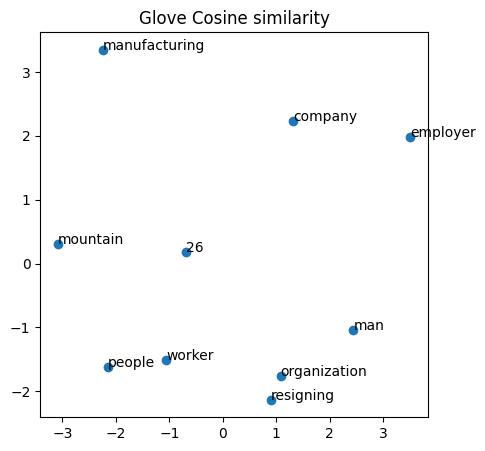

In [114]:
# Plot
plt.figure(figsize=(5,5))
plt.scatter(x=reduced['X'],y=reduced['Y'])
plt.title('Glove Cosine similarity')
for idx, value in reduced.iterrows():
    plt.annotate(reduced['word'][idx],value[:-1])

path = '/root/projects/NLP/Assignment/26_Jan_Depedency_Parser/output/Glove_weight/Glove_fig.png'
plt.savefig(path)

## Word2Vec

### Data/Function prepare

In [117]:
# Let's use the same dataset and code from data preparation
def random_batch(batch_size, word_sequence, window_size=1):

# I fix a little from Chaky so we can modify the window_size
    
    # Make skip gram of one size window
    skip_grams = []
    # loop each word sequence
    # we starts from 1 because 0 has no context
    # we stop at second last for the same reason
    for sent in corpus:
        for i in range(1, len(sent) - 1): # So we can modify the window size
            target = word2index[sent[i]]
            
            context = list()
            # ['a', 'b', 'c', 'd', 'e'] if window size = 2 and target is c
            # this is basically append 'b', 'd', 'a', 'e' into context
            
            for j in range(window_size):
                
                if i - (j + 1) >= 0: # Check if it outside of range from the left of list
                    context.append(word2index[sent[i - (j + 1)]])
                
                if i + (j + 1) < len(sent): # Check if it outside of range from the right of list
                    context.append(word2index[sent[i + (j + 1)]])
            
            #context = [word2index[sent[i - 1]], word2index[sent[i + 1]]]
            for w in context:
                skip_grams.append([target, w])
    
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams[i][1]])  # context word, e.g., 3
            
    return np.array(random_inputs), np.array(random_labels)

In [121]:
#testing the method
batch_size = 10 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus, 2)

print("Input: ", input_batch)
print("Target: ", target_batch)
#we will convert them to tensor during training, so don't worry...

Input:  [[2105]
 [1108]
 [2832]
 [4808]
 [1992]
 [2082]
 [3547]
 [2350]
 [2709]
 [4548]]
Target:  [[4976]
 [4073]
 [ 713]
 [2083]
 [2903]
 [ 906]
 [3801]
 [3065]
 [4745]
 [ 967]]


In [122]:
class Skipgram(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(Skipgram,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size)
        self.embedding_u = nn.Embedding(vocab_size, emb_size)
    
    def forward(self, center_words, target_words, all_vocabs):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        all_embeds    = self.embedding_u(all_vocabs) #   [batch_size, voc_size, emb_size]
        
        scores      = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]

        norm_scores = all_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, voc_size, emb_size] @ [batch_size, emb_size, 1] = [batch_size, voc_size, 1] = [batch_size, voc_size]

        nll = -torch.mean(torch.log(torch.exp(scores)/torch.sum(torch.exp(norm_scores), 1).unsqueeze(1))) # log-softmax
        # scalar (loss must be scalar)    
            
        return nll # negative log likelihood

In [123]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

#use for the normalized term in the probability calculation
all_vocabs = prepare_sequence(list(vocab), word2index).expand(batch_size, len(vocab))  # [batch_size, voc_size]
all_vocabs.shape

torch.Size([10, 5070])

### Skipgram training

In [124]:
batch_size     = 10 # mini-batch size
embedding_size = 50 #so we can later plot
model          = Skipgram(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [126]:
import time

# Training
start_train_time = time.time()
num_epochs = 5000
start = time.time()
with tqdm(total=num_epochs) as prog:
    for epoch in range(num_epochs):
        
        input_batch, target_batch = random_batch(batch_size, corpus, window_size=2)
        input_batch  = torch.LongTensor(input_batch)  #[batch_size, 1]
        target_batch = torch.LongTensor(target_batch) #[batch_size, 1]

        optimizer.zero_grad()
        loss = model(input_batch, target_batch, all_vocabs)
        
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 1000 == 0:
            end = time.time()
            epoch_mins, epoch_secs = epoch_time(start, end)
            print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")
            start = time.time()
        prog.update(1)

end_train_time = time.time()
train_time_mins, train_time_secs = epoch_time(start_train_time, end_train_time)
print(f'Total time use in skipgram with window size of 1 {train_time_mins} miniute(s) {train_time_secs} second')

path = '/root/projects/NLP/Assignment/26_Jan_Depedency_Parser/output/Skipgram_weight/Skipgram_5000.pth'
torch.save(model.state_dict(), path)

 20%|██        | 1000/5000 [02:56<11:42,  5.70it/s]

Epoch: 1000 | cost: 18.447308 | time: 2m 56s


 40%|███▉      | 1999/5000 [05:53<09:55,  5.04it/s]

Epoch: 2000 | cost: 18.276245 | time: 2m 56s


 60%|██████    | 3000/5000 [08:50<06:36,  5.04it/s]

Epoch: 3000 | cost: 17.172071 | time: 2m 57s


 80%|████████  | 4000/5000 [11:54<03:04,  5.41it/s]

Epoch: 4000 | cost: 14.540049 | time: 3m 3s


100%|██████████| 5000/5000 [14:52<00:00,  5.60it/s]

Epoch: 5000 | cost: 17.496342 | time: 2m 57s
Total time use in skipgram with window size of 1 14 miniute(s) 52 second


### Cosine similarity

In [130]:
# Let's declare some list of word that we want to plot

model = model.to(device)

cos_test_word_list = ['employer', 'worker', 'company', 'organization', 'manufacturing', '26',
'people', 'mountain', 'resigning', 'man']

# Convert them to embed
cos_test_emb_list = [get_embed(word, model) for word in cos_test_word_list]
print(len(cos_test_emb_list))

10


In [131]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
pca = PCA(n_components=2)
reduced = pca.fit(cos_test_emb_list).transform(cos_test_emb_list)
reduced = pd.DataFrame(reduced,columns=['X','Y'])
reduced['word'] = cos_test_word_list #adding columns
reduced.head()

,X,Y,word
0,0.944754,-1.520992,employer
1,-0.745860,-0.101556,worker
2,-0.408631,1.010221,company
3,-2.068842,1.093792,organization
4,0.998793,-2.682834,manufacturing


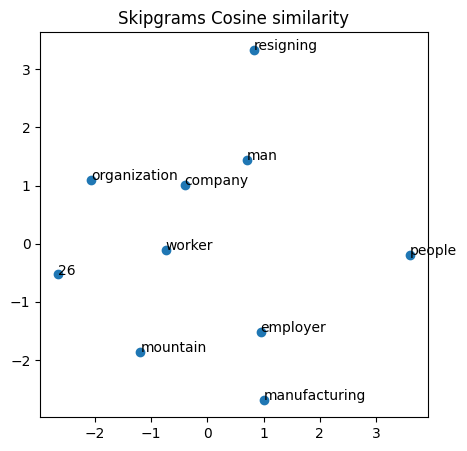

In [132]:
# Plot
plt.figure(figsize=(5,5))
plt.scatter(x=reduced['X'],y=reduced['Y'])
plt.title('Skipgrams Cosine similarity')
for idx, value in reduced.iterrows():
    plt.annotate(reduced['word'][idx],value[:-1])

path = '/root/projects/NLP/Assignment/26_Jan_Depedency_Parser/output/Skipgram_weight/Skipgrams_fig.png'
plt.savefig(path)

## Pre-embeded dataset
We do not need to do anything new, we just need to use the same code from above

In [134]:
train_set, dev_set, test_set = load_data()

print("2. Building parser")
start = time.time()
parser = Parser(train_set)
print("took {:.2f} seconds".format(time.time() - start))

train_set = parser.numericalize(train_set)
dev_set   = parser.numericalize(dev_set)
test_set  = parser.numericalize(test_set)

print("4. Loading pretrained embeddings...",)
start = time.time()
word_vectors = {}
for line in open("/root/projects/NLP/Assignment/26_Jan_Depedency_Parser/en-cw.txt").readlines():
    we = line.strip().split() #we = word embeddings - first column: word;  the rest is embedding
    word_vectors[we[0]] = [float(x) for x in we[1:]] #{word: [list of 50 numbers], nextword: [another list], so on...}
    
#create an empty embedding matrix holding the embedding lookup table (vocab size, embed dim)
#we use random.normal instead of zeros, to keep the embedding matrix arbitrary in case word vectors don't exist....
embeddings_matrix = np.asarray(np.random.normal(0, 0.9, (parser.n_tokens, 50)), dtype='float32')

for token in parser.tok2id:
        i = parser.tok2id[token]
        if token in word_vectors:
            embeddings_matrix[i] = word_vectors[token]
        elif token.lower() in word_vectors:
            embeddings_matrix[i] = word_vectors[token.lower()]
print("Embedding matrix shape (vocab, emb size): ", embeddings_matrix.shape)
print("took {:.2f} seconds".format(time.time() - start))


1. Loading data
2. Building parser
took 0.05 seconds
4. Loading pretrained embeddings...
Embedding matrix shape (vocab, emb size):  (5157, 50)
took 6.97 seconds


In [148]:
# Let's declare some list of word that we want to plot
cos_test_word_list = ['employer', 'worker', 'company', 'organization', 'manufacturing',
'people', 'mountain', 'resigning', 'man']

cos_test_preemb_list = [word_vectors[word] for word in cos_test_word_list]
# Noted: there is no 26 in this test because the pre-embeded that we use do not have this word
print(len(cos_test_preemb_list))

9


In [149]:
pca = PCA(n_components=2)
reduced = pca.fit(cos_test_preemb_list).transform(cos_test_preemb_list)
reduced = pd.DataFrame(reduced,columns=['X','Y'])
reduced['word'] = cos_test_word_list #adding columns
reduced.head()

,X,Y,word
0,2.164262,-2.416502,employer
1,0.325450,-2.584370,worker
2,-1.218122,-2.420501,company
3,-0.328885,-2.013297,organization
4,1.671002,-2.247920,manufacturing


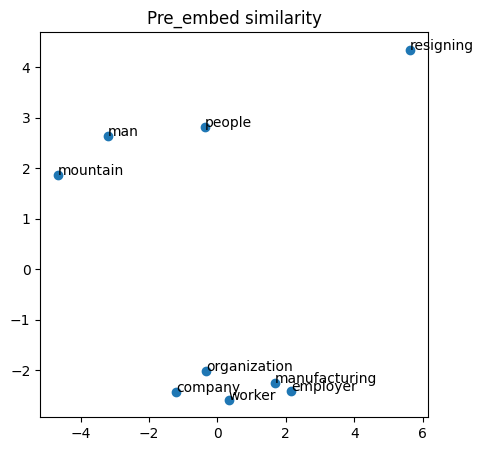

In [150]:
# Plot
plt.figure(figsize=(5,5))
plt.scatter(x=reduced['X'],y=reduced['Y'])
plt.title('Pre_embed similarity')
for idx, value in reduced.iterrows():
    plt.annotate(reduced['word'][idx],value[:-1])

path = '/root/projects/NLP/Assignment/26_Jan_Depedency_Parser/output/Pre_embed/Pre_embed_fig.png'
plt.savefig(path)

# Dependency comparision
Now, Let's try to compare the dependency of our neural network with spacy!

## Prepare some sentences

In [99]:
# Let's reload data because we want it's to be word
_, _, test_set = load_data()

1. Loading data


In [100]:
# Let's be picky, just get some short word
test_sentence = [sent for sent in test_set if len(sent['word']) < 10]


In [101]:
# Let's handpick some sentences for our model
test_sentence_1 = test_sentence[19] # ['the', 'centers', 'normally', 'are', 'closed', 'through', 'the', 'weekend', '.']
test_sentence_2 = test_sentence[20] # ['the', 'accord', 'expired', 'yesterday', '.']
test_sentence_3 = test_sentence[21] # ['martinair', 'holland', 'is', 'based', 'in', 'amsterdam', '.']

# To make it's the same format as we did above
test_our_model_sent = list()
test_our_model_sent.append(test_sentence_1)
test_our_model_sent.append(test_sentence_2)
test_our_model_sent.append(test_sentence_3)

In [106]:
# Let's print to check to be sure!
for sent in test_our_model_sent:
    print(sent['word'])

['the', 'centers', 'normally', 'are', 'closed', 'through', 'the', 'weekend', '.']
['the', 'accord', 'expired', 'yesterday', '.']
['martinair', 'holland', 'is', 'based', 'in', 'amsterdam', '.']


In [107]:
# Now, Numericalize its!
test_our_model_sent = parser.numericalize(test_our_model_sent)

for sent in test_our_model_sent:
    print(sent['word'])

[5156, 85, 5154, 3381, 116, 356, 379, 85, 4139, 87]
[5156, 85, 5154, 5154, 351, 87]
[5156, 5154, 5154, 102, 330, 91, 3516, 87]


In [63]:
# Prepare sentence for spacy
test_spacy_sent1 = 'the centers normally are closed through the weekend .'
test_spacy_sent2 = 'the accord expired yesterday .'
test_spacy_sent3 = 'martinair holland is based in amsterdam .'

test_spacy_sent = test_spacy_sent1,  test_spacy_sent2,  test_spacy_sent3

## Spacy

### Testing

In [66]:
#we eventually gonna make the dependency
#so maybe we can cheat a little bit, and see the answer

import spacy
from spacy import displacy #displacy is for visualization
nlp = spacy.load("en_core_web_sm")

for sent in test_spacy_sent:
    doc = nlp(sent)
    options = {"collapse_punct": False}
    displacy.render(doc, options = options, style="dep", jupyter=True)


## Our model

### Prepare model

In [26]:
# Get parser
#parser = Parser(train_set)
# Load model
model = ParserModel(embeddings_matrix)
model.eval()

parser.model = model
weight_path = '/root/projects/NLP/Assignment/26_Jan_Depedency_Parser/output/20230128_180042_All_features/model.weights'
parser.model.load_state_dict(torch.load(weight_path))
parser.model.eval()

ParserModel(
  (pretrained_embeddings): Embedding(5157, 50)
  (embed_to_hidden): Linear(in_features=2400, out_features=400, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (hidden_to_logits): Linear(in_features=400, out_features=3, bias=True)
)

### Testing

In [108]:
# Let get the dependencies
UAS, dependencies = parser.parse(test_our_model_sent)

6it [00:00, 9478.65it/s]             


In [109]:
dependencies

[[(2, 1), (5, 4), (5, 3), (5, 2), (8, 7), (8, 6), (5, 8), (5, 9), (0, 5)],
 [(2, 1), (4, 3), (2, 4), (2, 5), (0, 2)],
 [(2, 1), (4, 3), (4, 2), (6, 5), (4, 6), (4, 7), (0, 4)]]

<img src="../26_Jan_Depedency_Parser/dep_fig/test1.jpg">
<img src="../26_Jan_Depedency_Parser/dep_fig/test2.jpg">
<img src="../26_Jan_Depedency_Parser/dep_fig/test3.jpg">

# Conclusion

## Ablation studies
    In our model, we have mainly 3 features (word, pos, dep). I tried accroding to the assignment instruction and the results are displayed below.

| Case |     Features    | Dev UAS | Test UAS |
|------|:---------------:|---------|:--------:|
| 1    | Words, POS, DEP | 75.42   | 76.18    |
| 2    | Words, DEP      | 66.22   | 67.38    |
| 3    | Words, POS      | 75.62   | 77.68    |

    Surprisingly, case1 and case3 produce the same results (more or less). I think this can indicate that the dependencies feature is not significant or maybe worse. If we remove this feature maybe accruacy might be improved (need furthur study). In contrast POS is very significant in this case by cutting this feature. The accruacy drop around 8~10%.

## Embedding Comparision
    In this session I tried to compare the pre-embedding that we got from Chaky, Glove embedding that I train by my self for 5,000 epochs and Word2Vec Skipgrams (As it's the simplest form of usable nn.Embedding that I known).


<img src="/root/projects/NLP/Assignment/26_Jan_Depedency_Parser/output/Pre_embed/Pre_embed_fig.png">  
<img src="/root/projects/NLP/Assignment/26_Jan_Depedency_Parser/output/Glove_weight/Glove_fig.png">  
<img src="/root/projects/NLP/Assignment/26_Jan_Depedency_Parser/output/Skipgram_weight/Skipgrams_fig.png">  

    The pre_embed embedding work very well. It known that 'organization', 'worker', 'company', 'manufacturing' and 'employer' words are close together but it's a bit weird that 'resigning' and 'people' have a little distance.

    Surprisingly, glove embedding that train for 5,000 epochs can capture the relation between 'organization', 'man'
    and 'resignning'; 'people' and 'worker'. 
    Words 'company' and 'employer' are little close. I think this model is very powerful I think if we train more the accuracy can be improve.

    Lastly, Skipgrams that I trained for 5,000 epochs. Everything in the skipgrams seem to have the same distance. At least 'company' and 'man' 
    are a bit close. This indicate that word2vec with skipgrams is not good at capturing words relation.

## Sentence comparision
    I handpicked 3 sentences to compare. All of them do not have the same dependency but 80% similar. From my observation I think spaCy model is better. At the example 1 (pic 1 from above) our model see that 'weekend' depends on 'through' but spaCy predicted the opposite. All of the root are the same which is a good sign. I think the model that we used are around 60 ~ 70 % as powerful as spaCy.



